In [64]:
from langgraph.graph import END,START,StateGraph
from langchain_groq import ChatGroq
from typing import List,Annotated,TypedDict,Optional,Literal,Dict,Tuple,Any,Sequence
from  pydantic import BaseModel,Field
import operator
import pytesseract
from PIL import Image
from langgraph.checkpoint.memory import InMemorySaver
from langchain.tools import tool
from langgraph.types import interrupt, Command
import os
import operator

In [83]:
# Your api key for the llm
os.environ['GROQ_API_KEY'] =  ""



In [34]:
def take_last_value(left: Any, right: Any) -> Any:
    """A reducer that always takes the last (newest) value from the write sequence."""
    # When multiple values are written in a single step, they are passed as a sequence 
    # for reduction. We want the last one, as that's the result from text_to_queries.
    if isinstance(right, Sequence) and len(right) > 0:
        return right[-1]
    return right

In [35]:
def merge_dicts(left: Dict[str, str], right: Dict[str, str]) -> Dict[str, str]:
    if not isinstance(left, dict):
        left = {}
    if not isinstance(right, dict):
        return left
    return {**left, **right}

In [36]:
llm = ChatGroq(model = "llama-3.3-70b-versatile")

In [66]:
class Query(BaseModel):
    query1 : str
    query2 : str

class query_correct(BaseModel):
    reason : str      

class InvoiceState(TypedDict):
    upload_file_path : str
    image_text : str
    schema : str
    database_name : str
    tables_list : List[str]
    schemas : Dict[str,str]
    query : Annotated[str,take_last_value]
    reason : str
    human_fb : str
    max_tries : Annotated[int,operator.add] = 0
    #status : Literal["sucess","failed"]
    status : Annotated[Dict[str,str],merge_dicts]
    approved_queries: Optional[Dict[str, str]] 

In [67]:
def type_of_file(state:InvoiceState) -> Literal["image", "pdf","unknown"]:
    path = state['upload_file_path']
    extension = path.split('.')[-1]
    image_extensions = ["jpg", "jpeg", "png" ,"tiff", "tif", "webp","avif"]
    if extension in image_extensions :
        return "image"
    elif extension == "pdf" :
        return "pdf"
    else :
        return "unknown"

In [68]:
def image_to_text(state:InvoiceState) :
    path = state['upload_file_path']
    image = Image.open(path).convert("RGB")
    image_text = pytesseract.image_to_string(image)
    return {"image_text":image_text}
    

In [69]:
def pdf_to_image_to_text(state:InvoiceState) :
    path = state['upload_file_path']
    doc = pymupdf.open(path)
    pix = page.get_pixmap(dpi=300)
    img = Image.open(io.BytesIO(pix.tobytes("png")))
    img = np.array(img)
    if img.shape[-1] == 4:  # RGBA
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    text = pytesseract.image_to_string(img) 
    return {"image_text":image_text}
    

In [70]:
from langchain_core.tools import tool
import mysql.connector

@tool
def get_table_list(database_name: str):
    """
    Retrieve the list of table names from a given MySQL database.

    This function:
      - Connects to the specified MySQL database.
      - Executes the `SHOW TABLES` query.
      - Returns the table names in a dictionary format.

    Args:
        database_name (str): Name of the MySQL database to connect to.

    Returns:
        dict: 
            - On success: {"tables_list": ["table1", "table2", ...]}
            - On failure: {"error": "<error_message>"}
    """
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="vipin",
        database=database_name
    )
    mycursor = mydb.cursor()

    try:
        mycursor.execute("SHOW TABLES;")
        tuple_list = mycursor.fetchall()  # list of tuples like [('invoices',), ('users',)]
        tables_list = [tab[0] for tab in tuple_list]  # extract table names
        return {"tables_list": tables_list}

    except Exception as e:
        return {"error": str(e)}

    finally:
        mycursor.close()
        mydb.close()


In [71]:
import json
from langchain_core.tools import tool
import mysql.connector

@tool
def get_table_schema(database_name: str, table_list: List[str]):
    """
    Retrieve the schema (CREATE TABLE statements) of one or more tables
    from a given MySQL database.

    Args:
        database_name (str): Name of the MySQL database to connect to.
        table_list (list): A list containing the name of all the tables in database.

    Returns:
        dict: A dictionary with key as table name and value astheir CREATE TABLE statements.
              
        dict: If an error occurs, a dictionary with the key `error`
              containing the error message.
    """
    schema_dict = {}
    try:
        mydb = mysql.connector.connect(
            host="localhost",
            user="root",
            password="vipin",
            database=database_name
        )
        mycursor = mydb.cursor()
        for table in table_list:
            mycursor.execute(f"SHOW CREATE TABLE {table}")
            table_scm = mycursor.fetchall()
            schema_dict[table] = table_scm[0][1]

        return {"schemas": schema_dict}

    except Exception as e:
        return {"error": f"Database error: {str(e)}"}

    finally:
        if 'mycursor' in locals() and mycursor is not None:
            mycursor.close()
        if 'mydb' in locals() and mydb is not None:
            mydb.close()

In [72]:
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnablePassthrough
from typing import Dict, Any

def get_table_list_fn(state: InvoiceState):
    # Language model invocation prompt
    prompt = f"""
    Use the tool `get_table_list` to get all the tables available 
    in the database {state['database_name']}.
    """

    # Bind tools to the model
    llm_with_tools = llm.bind_tools([get_table_list])

    # Model invocation (returns AIMessage with .tool_calls)
    response: AIMessage = llm_with_tools.invoke(prompt)
 

    # Check tool_calls attribute
    if getattr(response, "tool_calls", None):
        for tool_call in response.tool_calls:
            if tool_call.get("name") == "get_table_list":
    
                tool_output = get_table_list.invoke(tool_call.get("args"))

                if "tables_list" in tool_output:
                    return {"tables_list": tool_output["tables_list"]}
                else:
                    print(f"Tool execution failed: {tool_output.get('error', 'Unknown error')}")
                    return {"tables_list": None, "error": tool_output.get('error', 'Unknown error')}
        print("LLM did not call get_table_list as expected.")
        return {"tables_list": None}
    else:
        print("LLM did not make a tool call as expected.")
        return {"tables_list": None}


In [73]:
from langchain_core.messages import AIMessage
from typing import Dict, Any
import json

def get_table_structure(state: InvoiceState) -> dict:
    """
    Retrieves the schema for each table in a given database using LangChain tool calling. 
    
    This function sends a prompt to a language model that is configured to call 
    the `get_table_schema` tool for every table. The tool calls are extracted 
    from the LLM response and executed manually. The results are aggregated into 
    a dictionary mapping table names to their schemas, which is then serialized 
    and returned under the 'schemas' key.
        
    Returns:
        dict: A dictonary containing key and value pairs.Key being the val.
    """
    database_name = state["database_name"]
    tables_list = state["tables_list"]
    
    llm = ChatGroq(model="llama-3.3-70b-versatile")
    llm_with_tools = llm.bind_tools([get_table_schema])

    
    prompt = f"""
You are a helpful assistant specializing in MySQL.

Your task is to call the tool and with the help it to get the table structure:
 1. The database name: `{database_name}`
 2. A list of tables in that database: {tables_list}



The function returns a dictionary where:
  - Each key is a table name
  - Each value is the query generated for that table

You must call the function once with the provided arguments.
"""

    # Invoke the LLM with the bound tools
    llm_response = llm_with_tools.invoke(prompt)

   
    
    # Ensure the response is an AIMessage and contains tool calls
    if isinstance(llm_response, AIMessage) and getattr(llm_response, "tool_calls", None):
        for tool_call in llm_response.tool_calls:
            if tool_call.get('name') == "get_table_schema":
                tool_args = tool_call.get('args', {})
                table_list = tool_args.get("table_list")
        
                if database_name and table_list:
                    # Call the schema tool manually per tool call
                    schema_result = get_table_schema.invoke(input = 
                        {"database_name":"invoices",
                        "table_list":table_list}
                    )
                    

    
    return schema_result


In [74]:
def text_to_queries(state: InvoiceState):
    image_text = str(state.get("image_text", ""))
    schemas = str(state.get("schemas", ""))
    reason = str(state.get("reason", ""))
    human_fb = str(state.get("human_fb", ""))

    prompt = f"""
    ```
You are a precise and reliable assistant that generates **two logically interlinked MySQL INSERT queries** from OCR invoice data.

You are given:
1. OCR extracted text from an invoice.
2. Database schema (for both tables).
3. Human feedback (manual corrections).
4. Quality checker feedback (error reasons).

Your task:
Generate **two INSERT queries** — both consistent and interlinked.

---

### INPUT DATA

1. **OCR Text:**
{image_text}

2. **Database Schema:**
{schemas}

3. **Human Feedback:**
{human_fb}

4. **Quality Checker Feedback:**
{reason}

---

### RULES

**Query 1 — `invoices` table**
- Contains invoice-level information only (e.g., invoice_numer, invoice_date, vendor_name, total_amount etc.).Follow the schema of invoices` table
- Total amount given in the schem is the total of the amount in invoice_items table so always modify it whever their is change in the amount in inoive_items table


**Query 2 — `invoice_items` table**
- Contains item-level details (item_name, quantity, unit_price, tax, amount, etc.).Follow the schema of invoice_items` table

- Always follow the schema and constrains given in the schema


**Interlink Logic**
- After making changes in Query 2:
  - Make the change in the items which were changed in another query or vice versa:  
- Reflect these recalculated changes accurately in Query 1.
- Any modification in Query 2 (items, prices, tax, or quantity) must **automatically update** Query 1 totals and other relevant details.
- Ensure currency and numeric precision (2 decimal places).


### EXAMPLES
**Given Data:**
- **OCR Text:** "Invoice #123, Date: 2023-10-01, Vendor: ABC Corp, Items: Item1, 2, 10.00, Item2, 1, 20.00"
- **Database Schema:** "Table invoices: (invoice_id, date, vendor_name, total_amount); Table invoice_items: (invoice_id, item_name, quantity, unit_price, tax, amount)"
- **Human Feedback:** "Correct item names and quantities."
- **Quality Checker Feedback:** "Total amount mismatch."

"""

    llm = ChatGroq(model="llama-3.3-70b-versatile")

    # Enforce structured output for JSON format
    structured_model = llm.with_structured_output(Query)
    query = structured_model.invoke(prompt)

    # Return updated query for downstream nodes
    return {"query": query.model_dump()}
    

In [75]:
def query_checker(state: InvoiceState):
    """
    Validate SQL queries against MySQL schema and business rules.

    - The assistant must check:
      1. Query syntax validity.
      2. Exact schema match (columns, datatypes, constraints).
      3. Foreign key and primary key relationships.
      4. That values in queries are consistent with the OCR extracted text.
      5. Missing column values must be set to NULL, not omitted.
      

    - Expected output format:
      {
        "reason": None | "<explanation of mistake>"
      }
    """

    structured_model = llm.with_structured_output(query_correct)

    prompt = f"""
You are a MySQL SQL query checker assistant.

You will be provided:
1. Extracted OCR text from an invoice (natural language content).
2. A MySQL schema (all relevant tables and constraints).
3. One or more SQL queries generated based on the OCR.
4. Human Feedback that was given to the SQL agent to generate query accordinly.
5. Any chaneges make by taking into considering the human feedback must be ignored by you.Keep the changes as it as.To look what human have given feedback it is given below and ignore it 

Your tasks:
- Check if each query strictly follows the provided schema (tables, columns, datatypes, constraints).
- Verify that all constraints are respected:
  - Primary keys must not conflict.
  - Foreign keys must correctly reference parent tables.
  - If a value is missing from OCR, explicitly use NULL.
- Ensure the queries are logically consistent with the OCR text (values should match invoice details).
- Do not invent or assume new columns or tables.

Output rules:
- Return JSON only.
- Key "reason":
   - If the queries are valid, return null.
   - If there is an issue, return a short explanation of the mistake.

Example outputs:
{{
  "reason": "None"
}}

{{
  "reason": "Column 'invoice_id' is missing in INSERT query for 'invoice_items'."
}}

Content (OCR extracted text):
{state['image_text']}

Schema:
{state['schemas']}

Queries to check:
{state["query"]}

Human Feedback :
{state.get("human_fb",'')}

"""

    result = structured_model.invoke(prompt).model_dump()
    return {
    "reason":state.get("reason","") + " . " +result["reason"] + "\n",  
    "max_tries": 1
}


In [76]:
def maxium_trilers(state:InvoiceState) :
    if state["max_tries"] < 3 :
      return "not_maxed_out"
    else :
      return "maxed_out"
    

In [78]:
def execute_query(state:InvoiceState) :
   import mysql.connector

   mydb = mysql.connector.connect(
      host="localhost",
      user="root",
      password="vipin",
      database = state["database_name"] 
    )
   mycursor = mydb.cursor() 
   queries =  state["query"]

   try :
       for key ,value in queries.items() :
           mycursor.execute(value)
           mydb.commit()
           state["status"] = {value:'status'}
       return state
   except Exception as e:
       state["status"] = {value :str(e)}
       return state 
   finally :
       mydb.close()



    

In [79]:
def human_node(state: InvoiceState) :#-> Command[Literal["execute_query", "text_to_queries"]]:
    """
    Pause workflow for human approval.
    Returns an Interrupt object carrying the current queries.
    """
    query = state["query"]  # fetch the generated queries from previous node

    # Prepare message for human review
    message = f"Please review the generated SQL queries:\nQuery1: {query['query1']}\nQuery2: {query['query2']}\nApprove or provide a reason for changes."

    # Pause the workflow and wait for input
    decision = interrupt(value={"type": "approval","message": message})

    if decision.lower() == "yes":
        return Command(goto="execute_query")
    else:
        return Command(goto="text_to_queries", update={"human_fb": state.get("human_fb","") + " . " +  decision.lower() + "\n"})
     

In [80]:
checkpointer = InMemorySaver()

In [81]:
graph = StateGraph(InvoiceState)

# graph.add_node("file_type", file_type)
# graph.add_node("type_of_file",type_of_file)

graph.add_node("image_to_text",image_to_text)
graph.add_node("pdf_to_image_to_text",pdf_to_image_to_text)
# graph.add_node("hepler_function",hepler_function)
graph.add_node("text_to_queries",text_to_queries)
graph.add_node("get_table_list_fn",get_table_list_fn)
graph.add_node("get_table_structure",get_table_structure)
graph.add_node("human_node", human_node)

graph.add_node("query_checker",query_checker)
graph.add_node("execute_query",execute_query) 

graph.add_conditional_edges(START,type_of_file,{"image":"image_to_text","pdf":"pdf_to_image_to_text","unknown":END})
graph.add_edge("image_to_text","get_table_list_fn")
graph.add_edge("pdf_to_image_to_text","get_table_list_fn")
#graph.add_edge("hepler_function","get_table_list_fn")
#graph.add_edge("hepler_function","text_to_queries")
#text_to_queries.requires = ["get_table_structure", "image_to_text"]
# graph.add_edge("pdf_to_image_to_text","text_to_queries")
graph.add_edge("get_table_list_fn","get_table_structure")
graph.add_edge("get_table_structure","text_to_queries")
graph.add_conditional_edges("text_to_queries",maxium_trilers,{"maxed_out":"human_node","not_maxed_out":"query_checker"})
#graph.add_conditional_edges(START,type_of_file,{"image":"image_to_text","pdf":"pdf_to_image_to_text","unknown":END})
graph.add_edge("query_checker","text_to_queries")
graph.add_edge("human_node","execute_query")
graph.add_edge("execute_query",END)

workflow = graph.compile(checkpointer=checkpointer)

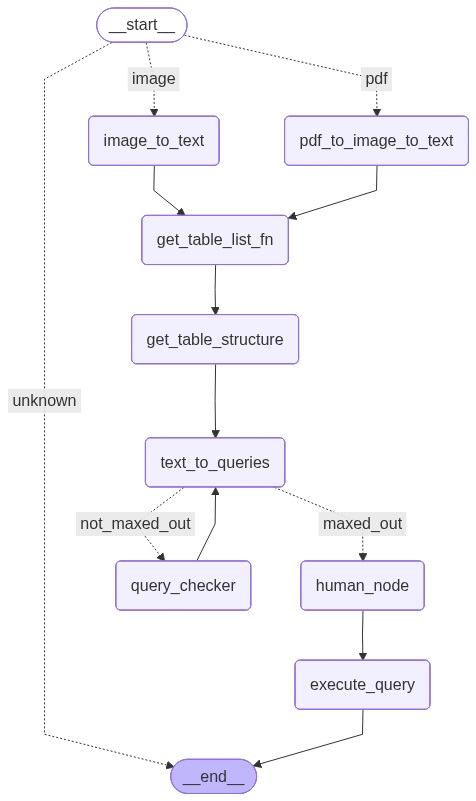

In [52]:
workflow

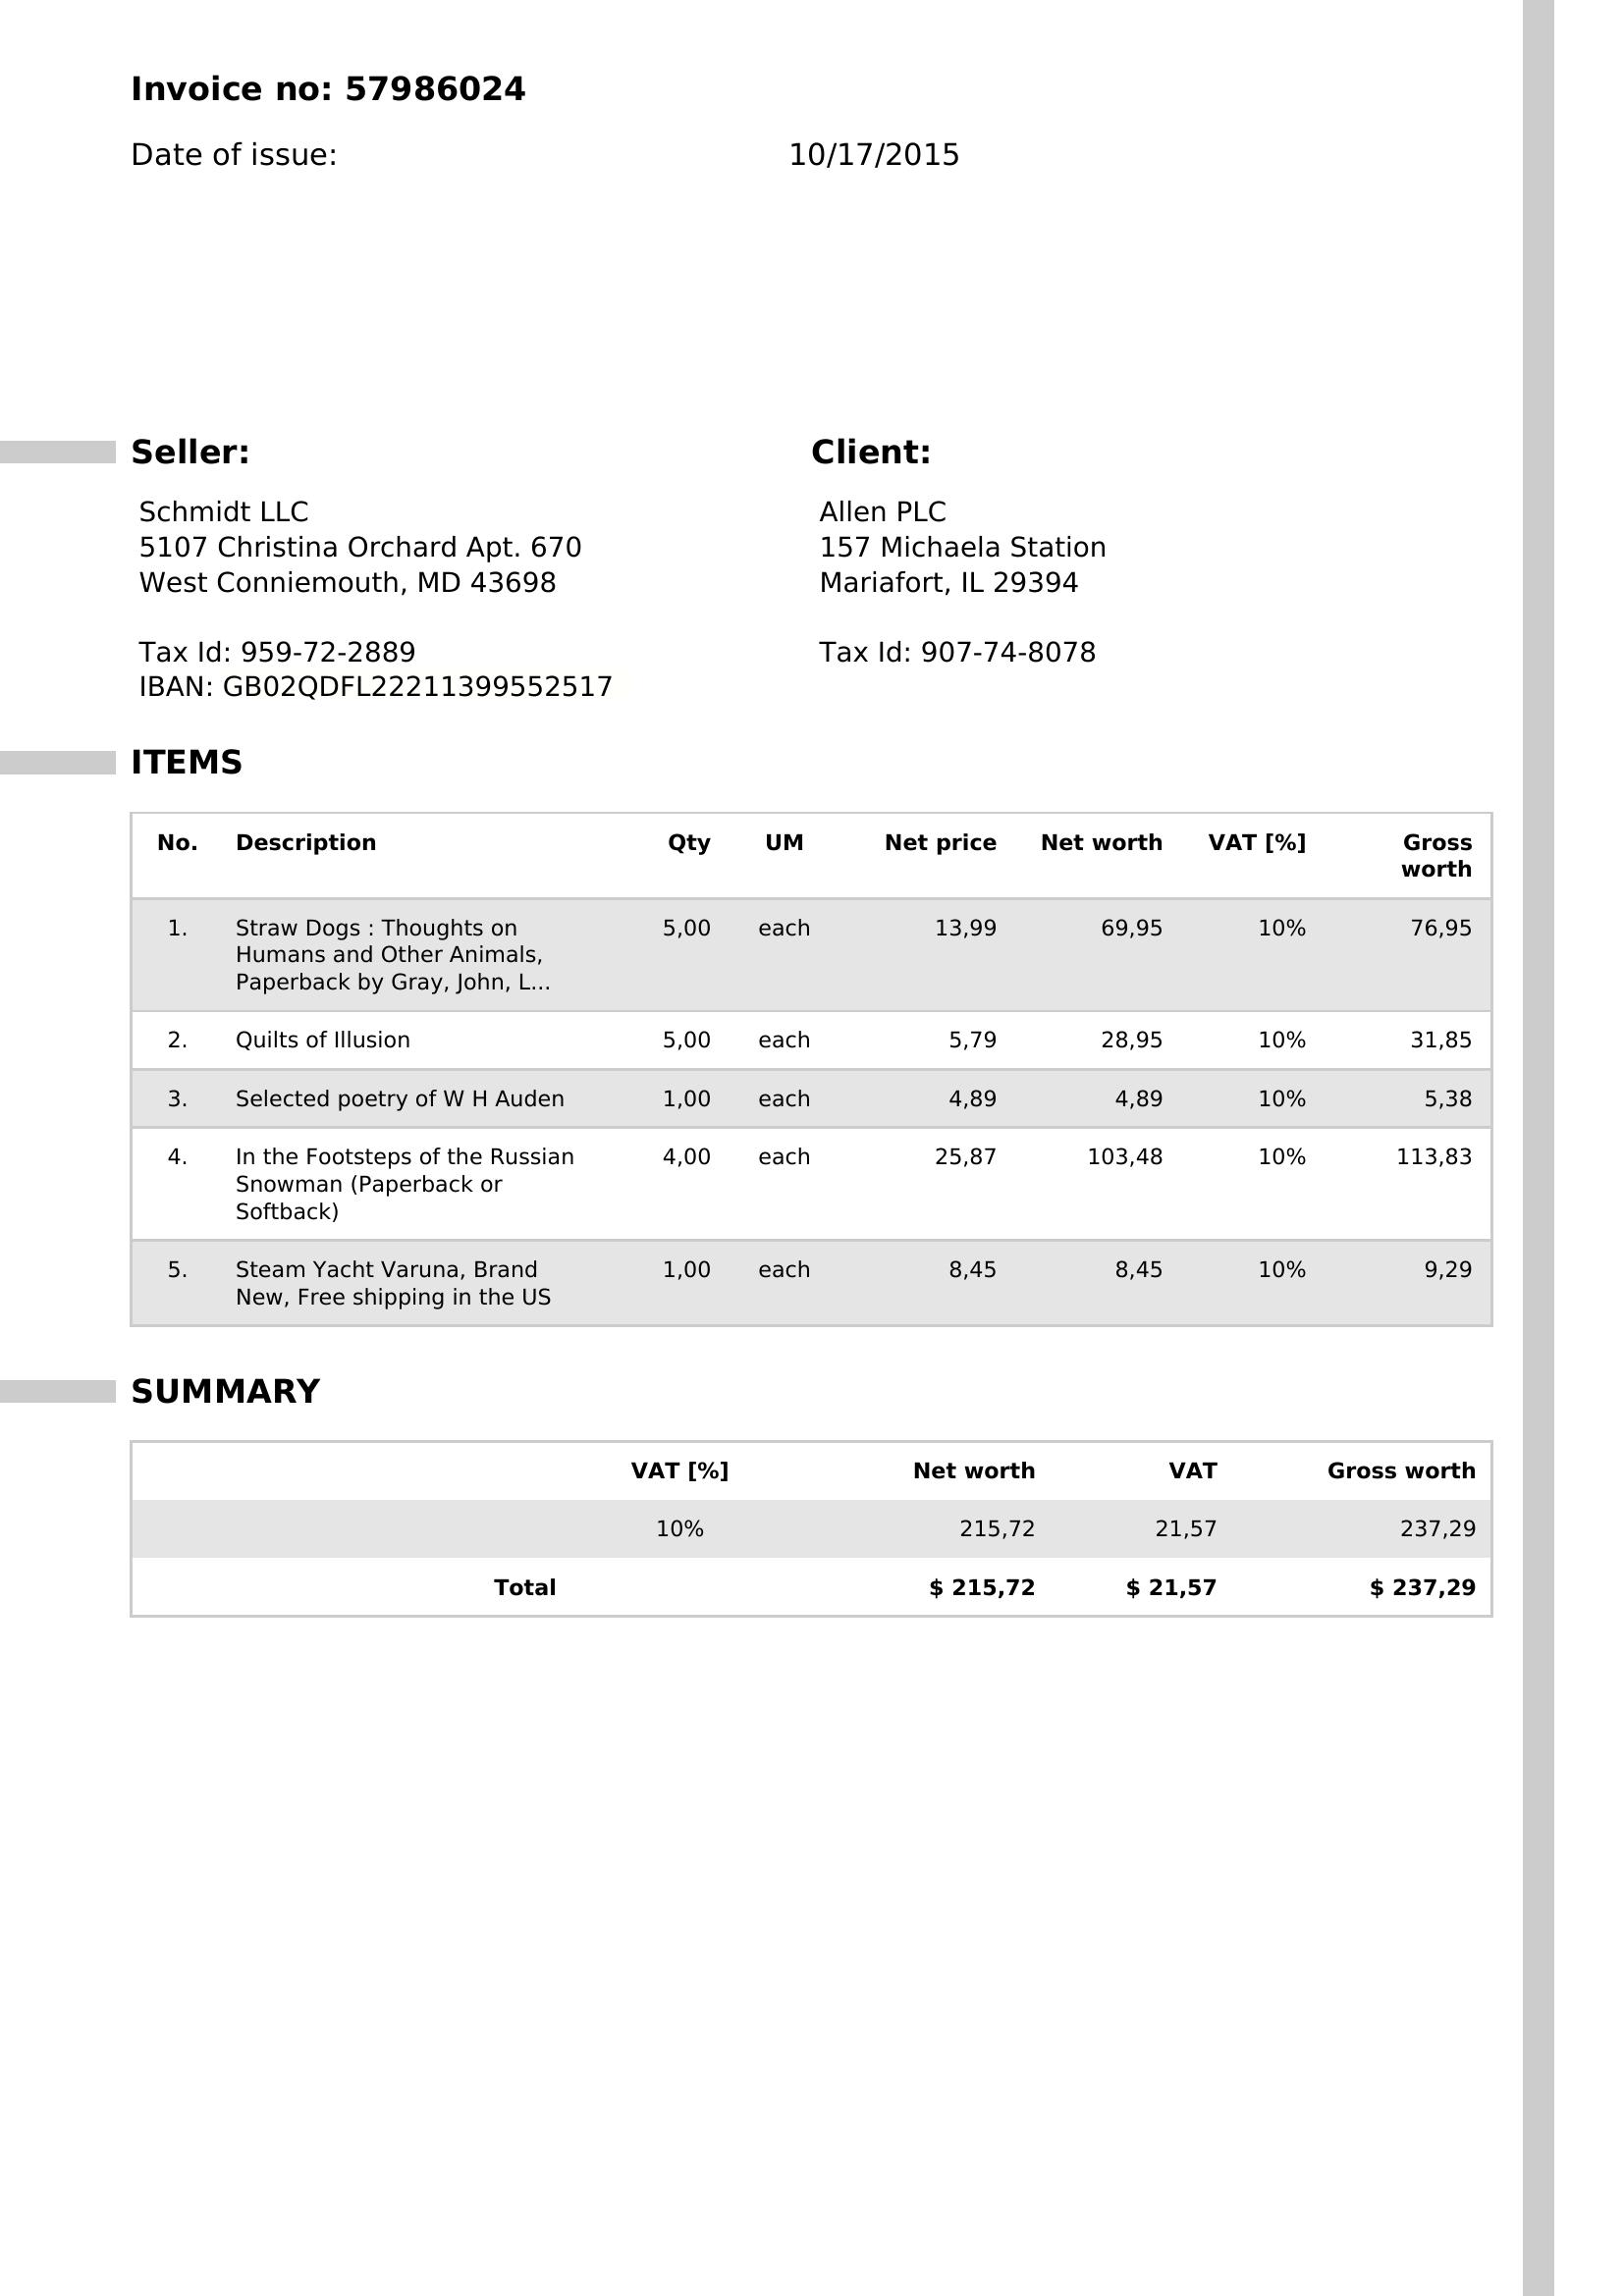

In [60]:
from PIL import Image
path = r"C:\Users\vipin\Downloads\invoice_img.jpg"
Image.open(path)

In [62]:
from langgraph.config import CONF
thread_id = "500"
config = {'configurable': {"thread_id":thread_id}}


In [63]:
output = workflow.invoke({"upload_file_path":path,"database_name" :"invoices","max_tries": 0},config=config,stream_mode="updates")


# 2. Check if workflow pausedyes
interrupts = output[-1]["__interrupt__"][0].value["message"]
if interrupts:
     print(interrupts)
     while True :
        interrupt_obj = interrupts[0]
        
    
        user_input = input("(Please check the query for execution type 'yes' to make the execution or to make any changes write the changes.) : ").strip()
    
        
        # Resume → go to execute_query
        output = workflow.invoke(Command(resume=user_input.lower()),config=config,debug = True,stream_mode = "updates")
        

        if  user_input.lower().strip() == "yes" :
            break
        print("------------------------",output[-1]["__interrupt__"][0].value["message"])    


Please review the generated SQL queries:
Query1: INSERT INTO invoices (invoice_number, vendor_name, customer_name, invoice_date, total_amount) VALUES ('57986024', 'Schmidt LLC', 'Allen PLC', '2015-10-17', 237.29)
Query2: INSERT INTO invoice_items (invoice_id, item_name, quantity, unit_price, tax_percentage, amount) VALUES (LAST_INSERT_ID(), 'Straw Dogs : Thoughts on Humans and Other Animals, Paperback by Gray, John, L...', 5, 13.99, 10, 76.95), (LAST_INSERT_ID(), 'Quilts of Illusion', 5, 5.79, 10, 31.85), (LAST_INSERT_ID(), 'BE Selected poetry of W H Auden', 1, 4.89, 10, 5.38), (LAST_INSERT_ID(), 'In the Footsteps of the Russian Snowman (Paperback or Softback)', 4, 25.87, 10, 113.83), (LAST_INSERT_ID(), 'Be Steam Yacht Varuna, Brand New, Free shipping in the US', 1, 8.45, 10, 9.29)
Approve or provide a reason for changes.


(Please check the query for execution type 'yes' to make the execution or to make any changes write the changes.) :  yes


[values] {'upload_file_path': 'C:\\Users\\vipin\\Downloads\\invoice_img.jpg', 'image_text': 'Invoice no: 57986024\n\nDate of issue:\n\nSeller:\n\nSchmidt LLC\n5107 Christina Orchard Apt. 670\nWest Conniemouth, MD 43698\n\nTax Id: 959-72-2889\nIBAN: GBO2QDFL22211399552517\n\nITEMS\nNo. Description Qty\n1. Straw Dogs : Thoughts on 5,00\n\nHumans and Other Animals,\nPaperback by Gray, John, L...\n\n2. Quilts of Illusion 5,00\nBE Selected poetry of W H Auden 1,00\n4. In the Footsteps of the Russian 4,00\nSnowman (Paperback or\nSoftback)\nBe Steam Yacht Varuna, Brand 1,00\n\nNew, Free shipping in the US\n\nSUMMARY\n\nVAT [%]\n10%\n\nTotal\n\n10/17/2015\n\nUM\n\neacn\n\neach\n\neacn\n\neacn\n\neacn\n\nClient:\nAllen PLC\n\n157 Michaela Station\nMariafort, IL 29394\n\nTax Id: 907-74-8078\n\nNet price\n\n13,99\n\n5,79\n\n4,89\n\n25,87\n\n8,45\n\nNet worth\n215,72\n\n$ 215,72\n\nNet worth VAT [%]\n69,95 10%\n28,95 10%\n\n4,89 10%\n103,48 10%\n8,45 10%\n\nVAT\n\n21,57\n\n$ 21,57\n\nGross\nworth\